# Plotting results of predictions




In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from matplotlib.colors import ListedColormap
import odc.geo
from odc.geo.xr import assign_crs
import folium

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools')
from dea_tools.temporal import allNaN_arg

## Calculate net ecosystem exchange

In [ ]:
# gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/GPP_2003_2021.nc')
# er = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/ER_2003_2021.nc')
# nee = er - gpp # reverse sign so that -ve is carbon sink
# nee.name = 'NEE'
# nee.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_2003_2021.nc')

## Analysis Parameters

In [2]:
var = 'NEE'
results_name = 'NEE_modelled_2003_2021.nc'
data_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/prediction_data_2003_2021.nc'

### Open predictions

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
# ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')

### Create a mask

In [4]:
data = xr.open_dataset(data_path)
mask = data.LAI.isnull().any('time')

## Facet plots

In [ ]:
year='2011'
ds.sel(time=year).plot.imshow(col='time', col_wrap=6, robust=True); 

In [ ]:
year='2019'
ds.sel(time=year).plot.imshow(col='time', col_wrap=6,  robust=True);

## Zonal summaries

In [5]:
ds_1D = ds.sum(['x','y'])
# ds_1D = ds.sum(['latitude','longitude'])

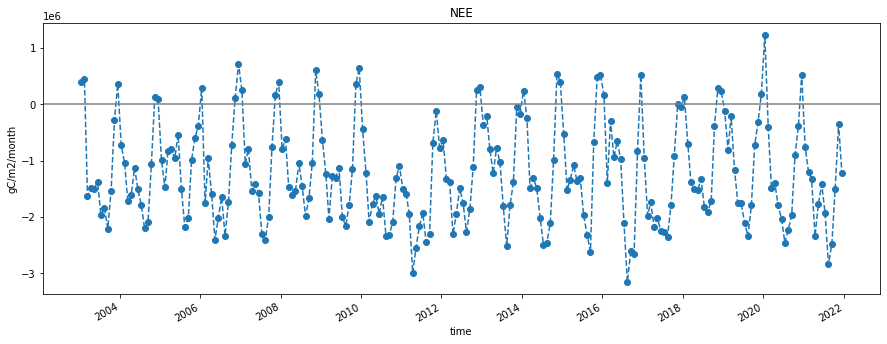

In [6]:
ds_1D.plot(figsize=(15,5), marker='o', linestyle='--')
plt.axhline(0, c='grey')
# plt.ylim(15000000,31000000)
plt.title(var)
plt.ylabel('gC/m2/month');


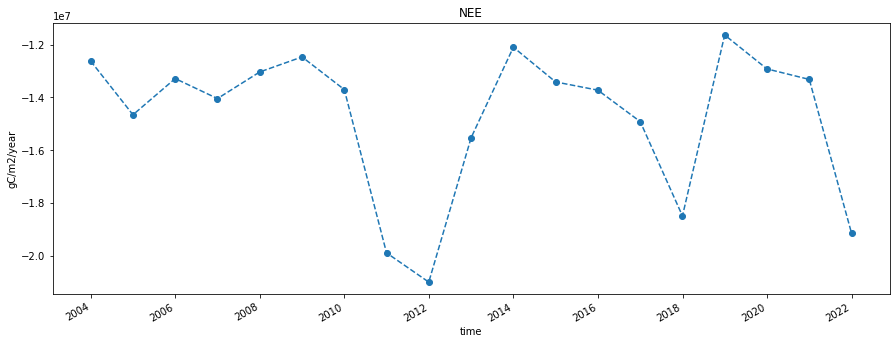

In [7]:
ds_1D_annual = ds.resample(time='1Y').sum().sum(['x','y'])
ds_1D_annual.plot(figsize=(15,5), marker='o', linestyle='--')
# plt.axhline(0, c='grey')
# plt.ylim(-3.0e7,-1.0e7)
plt.title
plt.title(var)
plt.ylabel('gC/m2/year');

In [ ]:
# y = monthly_mean.where(~mask).sum(['x','y']).values
# x = monthly_mean.month.values
# std = monthly_std.where(~mask).sum(['x','y']).values

# fig,ax = plt.subplots(1,1, figsize=(10,5))
# ax.plot(x, y, marker='o', linestyle='--')
# ax.axhline(0, c='grey')
# ax.fill_between(x, y-std, y+std, alpha=0.5)
# ax.set_title('Monthly Mean NEE summed over Australia');

## Per-pixel summaries

In [ ]:
annual_mean = ds.groupby('time.year').sum().mean('year')
annual_std = ds.groupby('time.year').sum().std('year')
scaled_variance = annual_std / annual_mean

In [ ]:
# write_cog(annual_mean, '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_annual_mean.tif')
# write_cog(annual_std, '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_annual_std.tif')

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(25,7), sharey=True)
annual_mean.where(annual_mean>0).plot.imshow(ax=ax[0], vmax=2000)  #cmap='RdBu_r'
annual_std.where(annual_std>0).plot.imshow(ax=ax[1], cmap='magma', robust=True)
np.absolute(scaled_variance).plot.imshow(ax=ax[2], cmap='magma', vmax=0.6)
ax[0].set_title('Annual Mean of '+var+', 2003-2021')
ax[1].set_title('Annual Std.Dev. in '+var+', 2003-2021')
ax[2].set_title('Coefficient of Variation, '+var+', 2003-2021')
# plt.suptitle('Annual Mean and Std. Dev. of GPP, 2003-2021')
plt.tight_layout();

In [ ]:
monthly_mean = ds.groupby('time.month').mean()
monthly_season = ds.groupby('time.season').mean()
monthly_std = ds.groupby('time.month').std()
cv_monthly = monthly_std / monthly_mean

In [ ]:
if var == 'NEE':
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'min')
    max_mean_season = allNaN_arg(monthly_season, 'season', 'min')
else:
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'max')
    max_mean_season = allNaN_arg(monthly_season, 'season', 'max')

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,10), sharey=True)

im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0], cmap='twilight', add_colorbar=False)
cbar = plt.colorbar(im, spacing='uniform', ax=ax[0])
cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])
ax[0].set_title('Month of maximum '+var);

cmap = ListedColormap(['lightsteelblue', 'cornflowerblue', 'royalblue', 'darkblue'])
im1 = max_mean_season.plot.imshow(vmin=1, vmax=4, cmap=cmap, add_colorbar=False, ax=ax[1])
cbar1 = plt.colorbar(im1, spacing='uniform', ax=ax[1])
cbar1.set_ticks([1, 2, 3, 4])
cbar1.set_ticklabels(["DJF", "MAM", "JJA", "SON"])
ax[1].set_title('Season of maximum '+var)
plt.tight_layout();

In [ ]:
# monthly_mean.where(~mask).plot.imshow(col='month', col_wrap=6, robust=True); #cmap='RdBu_r'

In [ ]:
# monthly_std.where(~mask).plot.imshow(col='month', col_wrap=6,robust=True, cmap='magma');

In [ ]:
# np.absolute(cv_monthly).where(~mask).plot.imshow(col='month', col_wrap=6,robust=True, cmap='magma');

In [ ]:
y = monthly_mean.where(~mask).mean(['x','y']).values
x = monthly_mean.month.values
std = monthly_std.where(~mask).mean(['x','y']).values

fig,ax = plt.subplots(1,1, figsize=(9,4))
ax.plot(x, y, marker='o', linestyle='--')
ax.axhline(0, c='grey')
ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean '+var+' averaged over Australia')
ax.set_xlabel('Month');
ax.set_ylabel('gC/m2/month');


## Interactive map

In [ ]:
# Create folium Map (ipyleaflet is also supported)
m = folium.Map()

# Plot each sample image with different colormap
# max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0], cmap='twilight', add_colorbar=False)
np.absolute(scaled_variance).where(~mask).odc.add_to(m, opacity=1.0, cmap='magma', vmax=2)
# assign_crs(max_mean_month, crs='epsg:4326').where(~mask).odc.add_to(m, opacity=1.0, cmap='twilight', vmin=1, vmax=12)


# Zoom map to Australia
m.fit_bounds(annual_mean.odc.map_bounds())

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)

folium.LayerControl().add_to(m)
display(m)

## Fluxcom

In [ ]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

In [8]:
var = 'nee'
ds_fc = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var+'_rs_meteo_era5.nc').sel(time=slice('2003','2018'))

In [ ]:
var='NEE'
monthly_mean = ds[var].groupby('time.month').mean()
monthly_std = ds[var].groupby('time.month').std()

y = monthly_mean.mean(['lat','lon']).values
x = monthly_mean.month.values
std = monthly_std.mean(['lat','lon']).values

fig,ax = plt.subplots(1,1, figsize=(9,4))
ax.plot(x, y, marker='o', linestyle='--')
ax.axhline(0, c='grey')
ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean '+var+' averaged over Australia')
ax.set_xlabel('Month');
ax.set_ylabel('gC/m2/day');

In [ ]:
nee_1D = (ds_fc.NEE*30).sum(['lat','lon'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(nee_1D.values.reshape(-1, 1))
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
normalized_fluxcom = scaler.transform(nee_1D.values.reshape(-1, 1))

# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = scaler.fit(ds_1D.values.reshape(-1, 1))

# normalize the dataset and print the first 5 rows
normalized_chad = scaler.transform(ds_1D.values.reshape(-1, 1))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(nee_1D.time.values, normalized_fluxcom, marker='o', linestyle='--')
ax.plot(ds_1D.time.values, normalized_chad, marker='o', linestyle='--')
# plt.axhline(0, c='grey')
plt.title('Fluxcom NEE')
plt.ylabel('gC/m2/month');

In [ ]:
nee_1D_annual = (ds_fc.NEE*30).resample(time='1Y').sum()
nee_1D_annual.sum(['lat','lon']).plot()
ds_1D_annual.plot()

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(nee_1D_annual.values.reshape(-1, 1))
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
normalized_fluxcom_annual = scaler.transform(nee_1D_annual.values.reshape(-1, 1))

# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = scaler.fit(ds_1D_annual.values.reshape(-1, 1))

# normalize the dataset and print the first 5 rows
normalized_chad_annual = scaler.transform(ds_1D_annual.values.reshape(-1, 1))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(nee_1D_annual.time.values, normalized_fluxcom_annual, marker='o', linestyle='--')
ax.plot(ds_1D_annual.time.values, normalized_chad_annual, marker='o', linestyle='--')
plt.axhline(0, c='grey')
plt.title('Fluxcom NEE')
plt.ylabel('gC/m2/year');

In [ ]:
year='2011'
nee.NEE.sel(time=year).plot.imshow(col='time', col_wrap=6, robust=True, cmap='RdBu_r');

In [ ]:
annual_mean = ds.NEE.groupby('time.year').sum().mean('year')
annual_std = ds.NEE.groupby('time.year').sum().std('year')
scaled_variance = annual_std / annual_mean

In [ ]:
# from odc.geo.xr import assign_crs
# write_cog(assign_crs(annual_std, crs='epsg:4326'), '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/FUXCOM_NEE_annual_std.tif')

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(25,7), sharey=True)
annual_mean.plot.imshow(ax=ax[0], robust=True)  #cmap='RdBu_r'
annual_std.where(annual_std>0).plot.imshow(ax=ax[1], cmap='magma', robust=True)
np.absolute(scaled_variance).plot.imshow(ax=ax[2], cmap='magma', vmax=1.5)
ax[0].set_title('Annual Mean of '+var+', 2003-2018')
ax[1].set_title('Annual Std.Dev. in '+var+', 2003-2018')
ax[2].set_title('Coefficient of Variation, '+var+', 2003-2018')
# plt.suptitle('Annual Mean and Std. Dev. of GPP, 2003-2021')
plt.tight_layout();


## SIF

In [ ]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
sif = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MODIS_GPP_1km_monthly_2002_2021.nc').sel(time=slice('2003','2021'))

In [ ]:
sif_1D = sif.sum(['latitude','longitude'])
sif_1D.plot(figsize=(15,5), marker='o', linestyle='--')
# plt.axhline(0, c='grey')
plt.title('GO-SIF');

In [ ]:
sif_1D_annual = sif_1D.resample(time='1Y').sum() 
sif_1D_annual.plot(figsize=(15,5), marker='o', linestyle='--')
# plt.axhline(0, c='grey')
plt.title('GOSIF');